In [120]:
from NN import *
from LTL import *
from Utility_funcs import *

from csrl.mdp import GridMDP
from csrl.oa import OmegaAutomaton
from csrl import ControlSynthesis
import numpy as np
import os

from matplotlib import pyplot as plt
import time 

Number of Omega-automaton states (including the trap state): 3


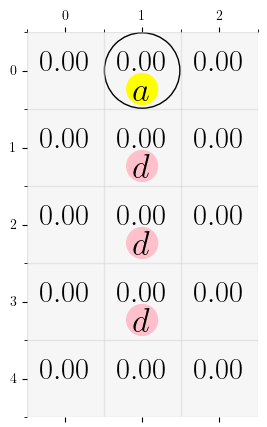

In [123]:
ltl = ("(G !d) & (F G a)")

# Translate the LTL formula to an LDBA
oa = OmegaAutomaton(ltl)
print('Number of Omega-automaton states (including the trap state):',oa.shape[1])

# MDP Description
shape = (5,3)
# E: Empty, T: Trap, B: Obstacle
structure = np.array([
['E',  'T',  'E'],
['E',  'E',  'E'],
['E',  'E',  'E'],
['E',  'E',  'E'],
['E',  'E',  'E'],
])

# Labels of the states
label = np.array([
[(),    ('a',),   ()],
[(),    ('d',),   ()],
[(),    ('d',),   ()],
[(),    ('d',),   ()],
[(),    (),   ()],
],dtype=object)
# Colors of the labels 
lcmap={
    ('a',):'yellow',
    ('b',):'greenyellow',
    ('c',):'turquoise',
    ('d',):'pink'
}
# u, d, r, l = moves
p = 0.7
grid_mdp = GridMDP(shape=shape,structure=structure,label=label,lcmap=lcmap, p=p, figsize=5)  # Use figsize=4 for smaller figures
grid_mdp.plot(save="env.pdf")

# Construct the product MDP
csrl = ControlSynthesis(grid_mdp,oa)
max_rew = round(csrl.reward.max(), 3)

s_vectors = state_vectors(csrl)
enc = list(np.unique(grid_mdp.label))
enc.pop(enc.index(()))
ch_states = channeled(csrl, enc)
total_number_of_states = csrl.mdp.shape[0]*csrl.mdp.shape[1]*csrl.oa.shape[1]

In [124]:
t = "[] ~d /\ (<> [] a)"

LTL_formula = parser.parse(t)
predicates=get_predicates(grid_mdp)
print(predicates)

{'a': [1], 'd': [4, 7, 10]}


In [125]:
model = build_model(ch_states[(0,0,0,0)].shape, csrl.shape[-1])
N, W, Q, P, visited = np.zeros(csrl.shape), np.zeros(csrl.shape), np.zeros(csrl.shape), np.zeros(csrl.shape), set()
# model.summary()

In [126]:
csrl.transition_probs[(0,0,1,1)][3]

([(0, 2, 2, 1), (0, 2, 0, 1), (0, 2, 1, 0)],
 [0.15000000000000002, 0.15000000000000002, 0.7])

In [130]:
visited_states_train = []
visited_states_test = []
LTL_coef = 10

search_depth = 30
MCTS_samples = 1000

num_training_epochs =  0
num_test_epochs = 100
training = True
epochs = 10
Cs = [0.01, 0.1, 1]
tows = [0.1, 0.5, 1]
T = [35]
K = 1
batch_size = 32
steps_per_epoch = 4
idx = 0
success_rates = []
succes_std = []
win_hist = []
train_history = []

os.remove("Log_run.txt")
for i in T:
    # C , tow = Cs[idx % 3], tows[idx // 3]
    C , tow = 0.01, 1
    print("C:",C, "| tow:",tow)
    idx += 1
    # TRAIN ##############################
    train_wins = 0
    # num_training_epochs = int(200 - 1.9*i)
    # model = build_model(ch_states[(0,0,0,0)].shape, csrl.shape[-1])
    N, W, Q, P, visited_train = np.zeros(csrl.shape), np.zeros(csrl.shape), np.zeros(csrl.shape), np.zeros(csrl.shape), set()
    for epoch in range(num_training_epochs):
        t1 = time.time()
        print(Q[(0,0,4,1)][:4], len(visited_train))
        state_history, channeled_states, trajectory, action_history, reward_history, better_policy = MC_learning(csrl, model, LTL_formula,
                predicates, csrl.reward, ch_states, N = N, W = W, Q = Q, P = P, C=C, tow=tow, n_samples=MCTS_samples, visited=visited_train,
                start=(4,1), search_depth=search_depth, verbose=0, T=i, K=K, run_num=epoch, ltl_f_rew=False)
        
        # print('N',N[(0,0,4,1)][:5])
        visited_states_train += state_history
        t2 = time.time()
        # print(t2-t1, " run episode")

        # win = check_LTL(LTL_formula, trajectory, predicates)[0]
        if reward_history[-1]>0: train_wins+=1

        if training and len(action_history)>0:
            if epoch==0:
                x_train = np.array(channeled_states)[:-1]
                y1_train = np.array(better_policy)
                y2_train = np.array(reward_history) + LTL_coef*reward_history[-1]
                # y2_train = np.array(reward_history)
                y2_train = y2_train[:-1]
            else:
                x_train = np.concatenate((x_train, np.array(channeled_states)[:-1]),0)
                y1_train = np.concatenate((y1_train, np.array(better_policy)),0)
                y2_train_curr = np.array(reward_history) + LTL_coef*reward_history[-1]
                # y2_train_curr = np.array(reward_history)
                y2_train = np.concatenate((y2_train, y2_train_curr[:-1]),0)
            t3= time.time()
            # print(t3-t2, " build database")
            tr_hist = model.fit(x_train, [y1_train, y2_train], epochs=epochs, batch_size=batch_size,
                                steps_per_epoch=steps_per_epoch if len(x_train)>steps_per_epoch*epochs*batch_size else None, verbose=0)
            train_history += tr_hist.history['loss']
        # win_hist.append(win)
        t4 = time.time()
        # print(t4-t3, "fit", len(x_train))
    print("Train wins:",train_wins,"/", num_training_epochs)

    # TEST ##############################
    test_wins = 0
    N, W, Q, P, visited_test = np.zeros(csrl.shape), np.zeros(csrl.shape), np.zeros(csrl.shape), np.zeros(csrl.shape), set()
    for epoch in range(num_test_epochs):
        
        state_history, channeled_states, trajectory, action_history, reward_history, better_policy = MC_learning(csrl, model, LTL_formula,
                predicates, csrl.reward, ch_states, N = N, W = W, Q = Q, P = P, C=1, tow=1, n_samples=MCTS_samples, visited=visited_test,
                start=(4,1), search_depth=search_depth, verbose=0, T=i, K=1, NN_value_active=True)

        # win = check_LTL(LTL_formula, trajectory, predicates)[0]
        win = reward_history[-1]
        if win: test_wins+=1
        win_hist.append(win)
        visited_states_test += state_history
        
    success_rates.append(100*test_wins/num_test_epochs)
    temp = np.zeros(num_test_epochs)
    temp[:test_wins]=1
    std = np.sqrt(num_test_epochs*np.var(temp))
    succes_std.append((success_rates[-1]-std, success_rates[-1]+std))
    ###############################################################
    print("Test wins:",test_wins,"/",num_test_epochs)
    # print("last reward:", reward_history[-1], "  | trajectory:", trajectory)
    # print("Actions:", action_history)

encode_visited_states_test = [i[1]*csrl.shape[-2]*csrl.shape[-3]+i[2]*csrl.shape[-2]+i[3] for i in visited_states_test]
encode_visited_states_train = [i[1]*csrl.shape[-2]*csrl.shape[-3]+i[2]*csrl.shape[-2]+i[3] for i in visited_states_train]

# u, d, r, l

C: 0.01 | tow: 1
Train wins: 0 / 0
None ) MCTS conf: -480.86 , det: 0.87 | LTL [+++]  LDBA [ 0.25 ] path: [13, 12, 9, 9, 9, 9, 6, 3, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]
None ) MCTS conf: -465.68 , det: 0.95 | LTL [+++]  LDBA [ 0.08 ] path: [13, 14, 11, 11, 11, 11, 11, 14, 11, 11, 11, 11, 11, 8, 8, 5, 5, 5, 2, 2, 5, 5, 5, 5, 5, 2, 1, 1, 1, 1, 1, 1, 1, 1, 1]
None ) MCTS conf: -451.97 , det: 0.98 | LTL [+++]  LDBA [ 0.08 ] path: [13, 14, 11, 14, 11, 11, 11, 11, 11, 11, 14, 11, 11, 11, 11, 11, 11, 8, 5, 5, 2, 5, 5, 5, 5, 2, 1, 1, 1, 1, 1, 1, 1, 1, 1]
None ) MCTS conf: -479.94 , det: 0.99 | LTL [---]  LDBA [ 0.0 ] path: [13, 10]
None ) MCTS conf: -460.32 , det: 0.99 | LTL [---]  LDBA [ 0.0 ] path: [13, 14, 11, 11, 11, 11, 11, 11, 11, 14, 11, 8, 7]
None ) MCTS conf: -444.12 , det: 0.99 | LTL [+++]  LDBA [ 0.26 ] path: [13, 13, 14, 11, 11, 8, 5, 2, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]
None ) MCTS conf: -4

KeyboardInterrupt: 

In [ ]:
# u, d, r, l

In [81]:
csrl.reward

array([[[[0.  , 0.  , 0.  ],
         [0.  , 0.  , 0.  ],
         [0.  , 0.  , 0.  ]],

        [[0.  , 0.01, 0.  ],
         [0.  , 0.  , 0.  ],
         [0.  , 0.  , 0.  ]],

        [[0.  , 0.  , 0.  ],
         [0.  , 0.  , 0.  ],
         [0.  , 0.  , 0.  ]]]])

In [84]:
state = (0, 1, 0, 1)
print(Q[state])
print(N[state])
csrl.transition_probs[state][5]

[0. 0. 0. 0. 0. 0. 0.]
[0. 0. 0. 0. 0. 0. 0.]
